# An SIR model for COVID-19

## Import packages

In [1]:
import datetime
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
import subprocess


# Import data

In [2]:
# Get the most recent data from https://github.com/CSSEGISandData/COVID-19
# which I have cloned in /Users/trevorkarn/covid_data/COVID-19

os.chdir('/Users/trevorkarn/covid_data/COVID-19')
os.system('git pull');

In [3]:
# The directory which has the exact data 
# I want for this simulation is in
data_dir = '/Users/trevorkarn/covid_data/COVID-19/csse_covid_19_data/csse_covid_19_time_series'

# There is a separate .csv file for each of
# "recovered", "deaths", and "confirmed"
# so we use glob to read them in and pandas
# to make them into data frames
data_names = glob.glob('/Users/trevorkarn/covid_data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/*.csv')
recovereddf = pd.read_csv(data_names[0])
deathsdf = pd.read_csv(data_names[1])
confirmeddf = pd.read_csv(data_names[2])

In [4]:
# Set the country you care about modeling
_COUNTRY_OF_INTEREST = "US"

# Aggregate all provinces within country of interest
recoveredvtime = recovereddf[recovereddf['Country/Region'] ==\
                             _COUNTRY_OF_INTEREST].sum(axis=0)[4:]
deathsvtime = deathsdf[deathsdf['Country/Region'] == \
                       _COUNTRY_OF_INTEREST].sum(axis=0)[4:]
sickvtime = confirmeddf[confirmeddf['Country/Region'] == \
                        _COUNTRY_OF_INTEREST].sum(axis=0)[4:]

I want to note that if someone wishes to 

In [5]:
# Combine recovered, deaths, and sick into one data frame
rds = pd.DataFrame(np.vstack((recoveredvtime,deathsvtime,sickvtime)),\
                   index=['recovered','deaths','cases'],columns=sickvtime.index)

# Set the first date from available data
first_data_date = datetime.datetime.strptime(rds.transpose().index[0],'%m/%d/%y')

# Set the most recent day for which we have data
recent_data_date = datetime.datetime.strptime(rds.transpose().index[-1],'%m/%d/%y')

## The model

### Brute force parameter tuning

In [6]:
true_data = rds.transpose()['cases'].values

S0 = 329968629 # US population according to Wikipedia

    # Set the initial conditions based on the first day 
    # for which CSSE has data 

I0 = rds.transpose()['cases'][0]
R0 = rds.transpose()['recovered'][0] 

Z0 = np.array([S0,I0,R0])
z0 = Z0/np.sum(Z0)

_N_DAYS = 200
t = np.arange(0,_N_DAYS)

beta_range = np.arange(0.2,0.31,.001)
kappa_range = 1/np.arange(10,20.5,.25)
minr2_param = [beta_range[0],kappa_range[0],100000]

for b,k in itertools.product(beta_range,kappa_range):
    
    def _SIR(t,z,b=b,k=k):

        s = z[0] # suceptable
        i = z[1] # infected
        r = z[2] # recovered

        ds = -b*s*i
        di = b*s*i-k*i
        dr = k*i

        return np.array([ds,di,dr])
    
    # How many days to forecast out
   

    # Use Scipy to solve the initial value problem
    sol = solve_ivp(_SIR,(0,_N_DAYS),z0,dense_output = True)

    # solutions
    s,i,r = sol.sol(t)
    model_data = S0*i[:len(true_data)]
    r2 = np.abs(r2_score(true_data,model_data))
    
    if r2 <= minr2_param[2]:
        minr2_param = [b,k,r2]
    

In [7]:
b,k,r2 = minr2_param

In [15]:
print(b,1/k,r2)

0.25400000000000006 11.5 -0.111


### Defining the model as a function

In [8]:
def SIR(t,z,b=b,k=k):
    
    s = z[0] # suceptable
    i = z[1] # infected
    r = z[2] # recovered
    
    ds = -b*s*i
    di = b*s*i-k*i
    dr = k*i
    
    return np.array([ds,di,dr])

## Initial conditions

In [9]:
S0 = 329968629 # US population according to Wikipedia

# Set the initial conditions based on the first day 
# for which CSSE has data 

I0 = rds.transpose()['cases'][0]
R0 = rds.transpose()['recovered'][0] 

Z0 = np.array([S0,I0,R0])
z0 = Z0/np.sum(Z0)

## Plot the true data

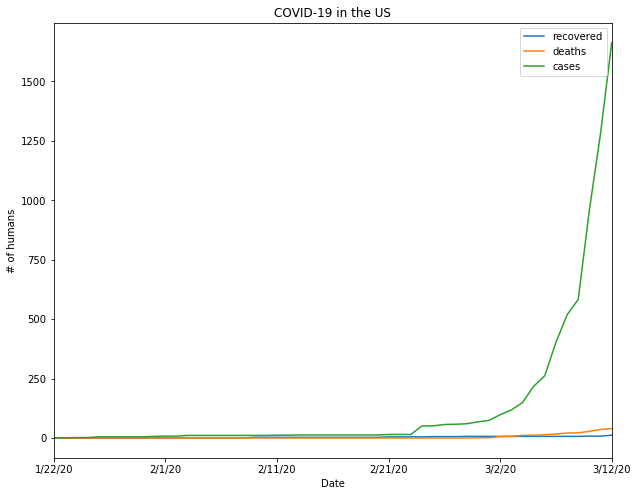

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
rds.transpose().plot()
plt.title('COVID-19 in the US')
plt.xlabel('Date')
plt.ylabel('# of humans')
plt.show()

## Solve the IVP for SIR model

In [11]:
# Solve and plot the solution

# How many days to forecast out
_N_DAYS = 200

# Use Scipy to solve the initial value problem
sol = solve_ivp(SIR,(0,_N_DAYS),z0,dense_output = True)

# Initialize a time vector for how many days
t = np.arange(0,_N_DAYS)

# Give the solutions to
# s = susceptible
# i = currently infected
# r = recovered
s,i,r = sol.sol(t)

# vectorize the datetime.timedelta function
vtd = np.vectorize(lambda dt: datetime.timedelta(days=int(dt)))

# Set the days offset by the first day
datetime_days = vtd(t)+first_data_date

# Forecast the day when things start to get better
print('According to this model, based on data as of %s:\n\n\
\tThe COVID-19 outbreak will peak in the US on %s'% \
    (datetime.datetime.strftime(recent_data_date,format='%B %d %Y'),
     datetime.datetime.strftime(datetime_days[i.argmax()],format='%B %d %Y')))

According to this model, based on data as of March 12 2020:

	The COVID-19 outbreak will peak in the US on May 26 2020


## Plot the full model

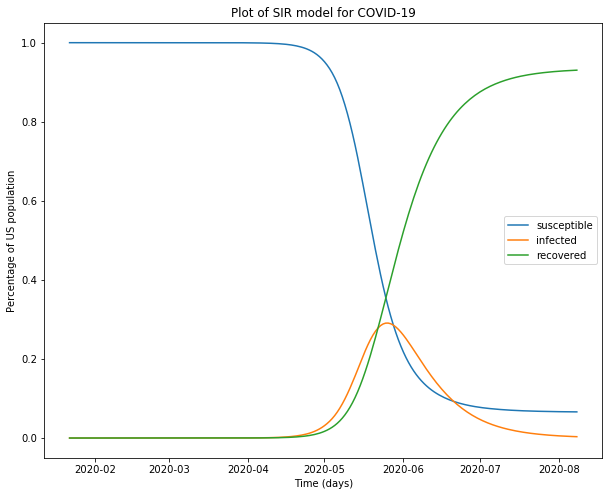

In [12]:
# Plot the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Plot of SIR model for COVID-19")
sns.lineplot(x=datetime_days,y=s,label='susceptible')
sns.lineplot(x=datetime_days,y=i,label='infected')
sns.lineplot(x=datetime_days,y=r,label='recovered')
plt.ylabel("Percentage of %s population"%_COUNTRY_OF_INTEREST)
plt.xlabel("Time (days)")
plt.show()

## Plot the model up to now, against current data

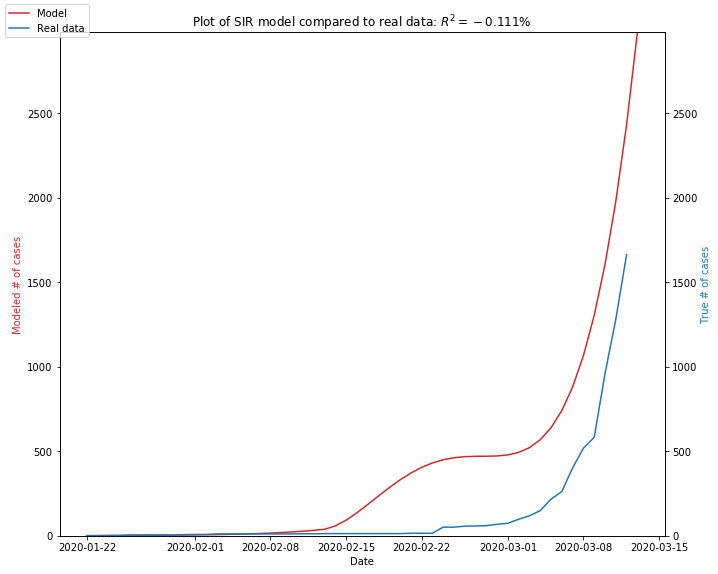

In [34]:
# from https://matplotlib.org/gallery/api/two_scales.html

true_data = rds.transpose()['cases'].values

plt.rcParams["figure.figsize"] = (10,8)

fig, ax1 = plt.subplots()

model_data = S0*i[:len(true_data)]

r2 = np.round(r2_score(true_data,model_data)*100,3)

plt.title('Plot of SIR model compared to real data: $R^2=%s$%%'%r2)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Modeled # of cases', color=color)
ax1.set_ylim([0,i[len(true_data)]*S0])
plot_model_len = len(true_data)+1
ax1.plot(datetime_days[:plot_model_len], S0*i[:plot_model_len], color=color)
#ax1.plot(list(range(plot_model_len)), S0*i[:plot_model_len], color=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('True # of cases', color=color) 
#ax2.set_ylim([0,true_data[-1]])
ax2.set_ylim([0,i[len(true_data)]*S0])
ax2.plot(datetime_days[:len(true_data)], true_data, color=color)
#ax2.plot(list(range(len(true_data)-2)), true_data[2:], color=color)

fig.legend(labels = ['Model','Real data'],loc=2)

fig.tight_layout() 
plt.show()